In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
from numpy import sin, cos, tan, pi
from control import TransferFunction as TF

In [2]:
import txt_mixin

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
import py_block_diagram

In [5]:
import importlib

In [6]:
importlib.reload(py_block_diagram)

<module 'py_block_diagram' from '/home/ryanwkrauss/git/py_block_diagram/py_block_diagram/__init__.py'>

In [7]:
import py_block_diagram as pybd

## System Description

In [8]:
U = pybd.step_input("$U(s)$")

In [9]:
sum1 = pybd.summing_junction(U,radius=0.35)

In [10]:
U.place_absolute(0,0)

In [11]:
sum1.place_relative(U,"right")

In [12]:
D = pybd.PD_controller(3, 0.1, sum1, "$D(s)$")

In [13]:
D.place_relative(sum1, "right",3.5)

In [14]:
D.input

In [15]:
sat = pybd.saturation_block("sat",D)

In [16]:
sat.place_relative(D, "right",5)

In [17]:
encoder = pybd.encoder(11)

In [18]:
HB = pybd.h_bridge(6,4,9)

In [19]:
G = pybd.plant(encoder,HB,"$G(s)$",sat)

In [20]:
G.place_relative(sat,"right",5)

In [21]:
sum1.input2 = G

### Custom sensor for accel

- the class `azaccel6050` is defined in the `.ino` template file
    - not in the `rtblockdiagram` library
- `accelgyro` is an instance of the `MPU6050` library's main class
- the `azaccel6050` class' main job is to wrap the reading of the accelerometer in the official `get_reading` method that the plant class will call

```
azaccel6050 myaccel = azaccel6050();
```

In [22]:
accel = pybd.custom_sensor("myaccel", "azaccel6050", "&accelgyro")

In [23]:
Ga = pybd.plant_no_actuator(accel,"$G_a(s)$",G,variable_name="Ga")

In [24]:
Ga.place_relative(G, "right", 5)

In [25]:
#Y = pybd.output_block("$Y(s)$",G)
#Y.place_relative(G, "right",6)

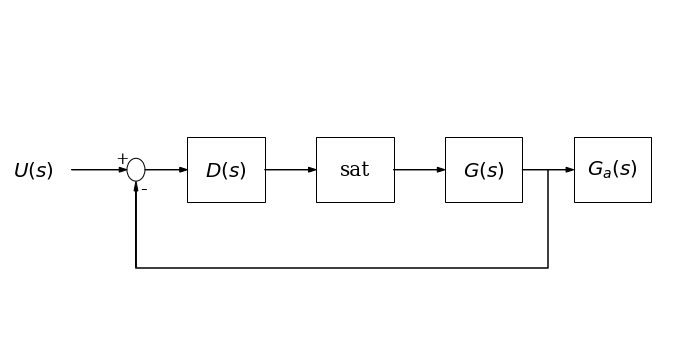

In [26]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
mysys = pybd.block_diagram([U,sum1,D,sat,G,Ga],ax)
mysys.draw()
plt.xlim([-1,25])
plt.ylim([-5,5])
mysys.axis_off()

## Codegen Test

In [27]:
msg = "Arduino codegen test 3 - MPU6050 accel z"

In [28]:
mysys.welcome_msg = msg

In [29]:
mysys.get_arduino_init_code()

['step_input u = step_input(0.1, 100);',
 'summing_junction sum1 = summing_junction();',
 'PD_control_block PD = PD_control_block(3, 0.1);',
 'saturation_block sat_block = saturation_block();',
 'h_bridge_actuator HB = h_bridge_actuator(6, 4, 9);',
 'encoder enc = encoder(11);',
 '',
 'void enc_isr_wrapper() {',
 '    enc.encoderISR();',
 '}',
 '',
 'plant G = plant(&HB, &enc);',
 'azaccel6050 myaccel = azaccel6050(&accelgyro);',
 'plant_no_actuator Ga = plant_no_actuator(&myaccel);']

## Note to self:

Right now, a plant block in the Arduino library does not have an input pointer
- the input is passed in explicitly
- this seems fairly inconsistent

In [30]:
template_fn = "arduino_template3_accel.ino"

In [31]:
mysys.generate_arduino_code("autogen3", template_fn)

In [32]:
mysys.arduino_file.list

['// I2C device class (I2Cdev) demonstration Arduino sketch for MPU6050 class',
 '// 10/7/2011 by Jeff Rowberg <jeff@rowberg.net>',
 '// Updates should (hopefully) always be available at https://github.com/jrowberg/i2cdevlib',
 '//',
 '// Changelog:',
 '//      2013-05-08 - added multiple output formats',
 '//                 - added seamless Fastwire support',
 '//      2011-10-07 - initial release',
 '',
 '/* ============================================',
 'I2Cdev device library code is placed under the MIT license',
 'Copyright (c) 2011 Jeff Rowberg',
 '',
 'Permission is hereby granted, free of charge, to any person obtaining a copy',
 'of this software and associated documentation files (the "Software"), to deal',
 'in the Software without restriction, including without limitation the rights',
 'to use, copy, modify, merge, publish, distribute, sublicense, and/or sell',
 'copies of the Software, and to permit persons to whom the Software is',
 'furnished to do so, subject to the f